# ** WALMART STORE SALES FORECASTING** **

In [0]:
'''Import necessary packages'''
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error # somewhat sensitive to outliers
from sklearn.metrics import median_absolute_error # insensitive to outliers
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
!pip install joblib
import joblib
!pip install xgboost
from xgboost import XGBRegressor

%matplotlib inline

#  Reading data into the notebook

In [0]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
import io
train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# Dataset is now stored in a Pandas Dataframe

In [0]:
print(train_df.shape)
train_df.head(3)

(421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


# **PRE-PROCESS DATA**

1. Sorting & train-test split

In [0]:
# Sorting data based on date
train_df.sort_values(by = ["Date"],inplace = True)
print(train_df.head(5))

        Store  Dept        Date  Weekly_Sales  IsHoliday
0           1     1  2010-02-05      24924.50      False
277665     29     5  2010-02-05      15552.08      False
277808     29     6  2010-02-05       3200.22      False
277951     29     7  2010-02-05      10820.05      False
278094     29     8  2010-02-05      20055.64      False


In [0]:
'''Define functions to split data,'''

def split_df(df,num):
    return df[ :num].copy(),df[num: ].copy()

In [0]:
# Convert date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [0]:
df_train_valid,df_test = split_df(train_df,305000)

print(df_train_valid.shape,df_test.shape)

(305000, 5) (116570, 5)


# **Data Exploration**

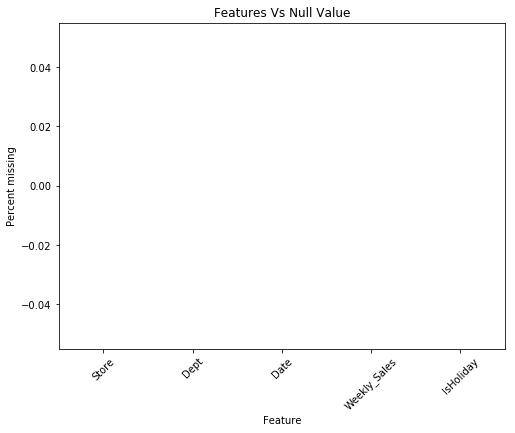

In [0]:
''' Deal with missing values. Calculating the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = df_train_valid.isnull().sum()/len(df_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
plt.title('Features Vs Null Value')
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [0]:
def scatter(df_train_valid, column):
    plt.figure()
    plt.scatter(df_train_valid[column] , df_train_valid['Weekly_Sales'])
    plt.ylabel('weeklySales')
    plt.xlabel(column)

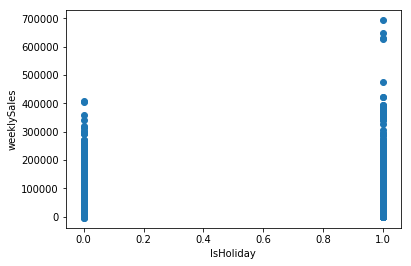

In [0]:
scatter(df_train_valid, 'IsHoliday')

In [0]:
'''From the graph, we can see that maximum sale occured on holiday '''

'From the graph, we can see that maximum sale occured on holiday '

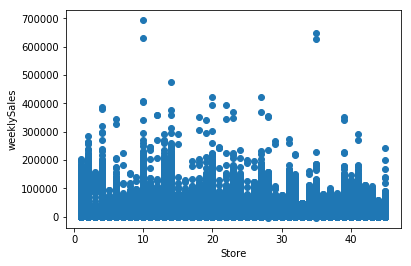

In [0]:
scatter(df_train_valid, 'Store')

In [0]:
'''From the graph, we can deduct that maximum sale occurs in store 10  '''

'From the graph, we can deduct that maximum sale occurs in store 10  '

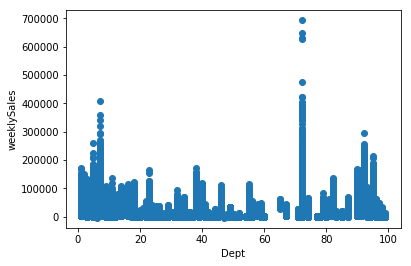

In [0]:
scatter(df_train_valid, 'Dept')

In [0]:
'''From the graph, we can deduct that maximum sale occurs in dept 72. Majority of the weekly sale is below 200000 '''

'From the graph, we can deduct that maximum sale occurs in dept 72. Majority of the weekly sale is below 200000 '

# **Confirming our observations**

In [0]:
'''Here we can see the maximum weekly_sale is 693099.360000. Also an interesting observation is 
that weekly_sale contains NEGATIVE VALUE which is not acceptable. So we need remove records with negative
weekly sale from our dataframe'''
df_train_valid["Weekly_Sales"].describe()

count    305000.000000
mean      16044.279683
std       22922.901520
min       -4988.940000
25%        2120.045000
50%        7665.375000
75%       20246.832500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [0]:
max_weekly_sale = df_train_valid[df_train_valid["Weekly_Sales"] == 693099.360000]
max_weekly_sale

,Store,Dept,Date,Weekly_Sales,IsHoliday
95373,10,72,2010-11-26,693099.36,True


# **Correlations between different variables in a dataframe:**

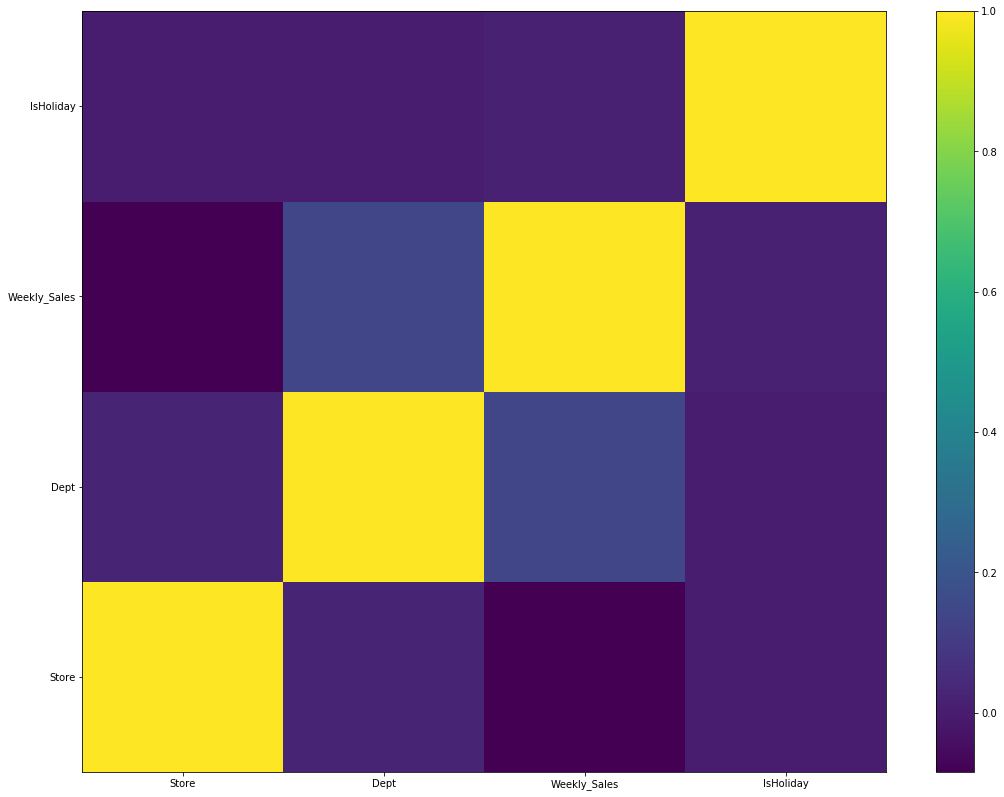

In [0]:
fig = plt.figure(figsize=(18, 14))
corr = df_train_valid.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

# **2. Drop records with negative weekly sale**

In [0]:
'''There are 913 records that contains weekly sale with negative value. Let us next check if there are any records 
with 0 weekly sale'''

neg_weekly_sale=df_train_valid[df_train_valid.Weekly_Sales < 0]
print (neg_weekly_sale.shape)

(913, 5)


In [0]:
'''We can see that there are 58 records with 0 weekly sale.'''
zero_weekly_sale = df_train_valid[df_train_valid["Weekly_Sales"] == 0]
print (zero_weekly_sale.shape)

(58, 5)


In [0]:
''' The negative weekly sale may be due to the misplaced negative sign while entering/inserting the weekly sale.
Since we cannot make assumptions, we are dropping these records '''
df_train_valid_1=df_train_valid[df_train_valid.Weekly_Sales >= 0]
print (df_train_valid_1.shape)

(304087, 5)


In [0]:
df_train_valid_1.describe()

,Store,Dept,Weekly_Sales
count,304087.000000,304087.000000,304087.000000
mean,22.177153,44.168412,16092.672786
std,12.782614,30.447426,22940.238125
min,1.000000,1.000000,0.000000
25%,11.000000,18.000000,2157.470000
50%,22.000000,37.000000,7715.350000
75%,33.000000,72.000000,20303.785000
max,45.000000,99.000000,693099.360000


# **3. Splitting dates and processing data**

In [0]:
'''Define functions to preprocess data - split dates, categorize, impute'''

def split_dates(df,date_column):
    date_df = pd.DataFrame({"year": df[date_column].dt.year,
              "month": df[date_column].dt.month,
              "day": df[date_column].dt.day,
              "dayofyear": df[date_column].dt.dayofyear,
              "week": df[date_column].dt.week,
              "weekofyear": df[date_column].dt.weekofyear,
              "dayofweek": df[date_column].dt.dayofweek,
              "weekday": df[date_column].dt.weekday,
              "quarter": df[date_column].dt.quarter,
             })
    df = df.drop(date_column,axis = 1)
    df = pd.concat([df,date_df],axis = 1)
    return df

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [0]:
# Splitting dates
df_train_valid_2 = split_dates(df_train_valid_1,"Date")
print(df_train_valid_2.shape)

(304087, 13)


In [0]:
# Converting string to category
df_train_valid_3 = str_to_cat(df_train_valid_2)
print(df_train_valid_3.shape)
df_train_valid_3.head(3)

(304087, 13)


,Store,Dept,Weekly_Sales,IsHoliday,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,1,1,24924.50,False,2010,2,5,36,5,5,4,4,1
277665,29,5,15552.08,False,2010,2,5,36,5,5,4,4,1
277808,29,6,3200.22,False,2010,2,5,36,5,5,4,4,1


In [0]:
# Imputing null values. From data exploration graphs we can see that there are no null values in the train dataframe.
train_processed,my_table = mydf_preprocessor(df_train_valid_3,null_table = None)
print(train_processed.shape)
train_processed.head(3)

(304087, 13)


,Store,Dept,Weekly_Sales,IsHoliday,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,1,1,24924.50,False,2010,2,5,36,5,5,4,4,1
277665,29,5,15552.08,False,2010,2,5,36,5,5,4,4,1
277808,29,6,3200.22,False,2010,2,5,36,5,5,4,4,1


In [0]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304087 entries, 0 to 158711
Data columns (total 13 columns):
Store           304087 non-null int64
Dept            304087 non-null int64
Weekly_Sales    304087 non-null float64
IsHoliday       304087 non-null bool
year            304087 non-null int64
month           304087 non-null int64
day             304087 non-null int64
dayofyear       304087 non-null int64
week            304087 non-null int64
weekofyear      304087 non-null int64
dayofweek       304087 non-null int64
weekday         304087 non-null int64
quarter         304087 non-null int64
dtypes: bool(1), float64(1), int64(11)
memory usage: 30.4 MB


In [0]:
my_table

{}

In [0]:
train_processed.head()

,Store,Dept,Weekly_Sales,IsHoliday,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,1,1,24924.50,False,2010,2,5,36,5,5,4,4,1
277665,29,5,15552.08,False,2010,2,5,36,5,5,4,4,1
277808,29,6,3200.22,False,2010,2,5,36,5,5,4,4,1
277951,29,7,10820.05,False,2010,2,5,36,5,5,4,4,1
278094,29,8,20055.64,False,2010,2,5,36,5,5,4,4,1


In [0]:
Y = train_processed["Weekly_Sales"]
X = train_processed.drop(["Weekly_Sales"],axis = 1)

In [0]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively'''

X_train,X_valid = split_df(X,260000)
Y_train,Y_valid = split_df(Y,260000)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)

(260000, 12) (44087, 12) (260000,) (44087,)


# **Preprocessing Test data**

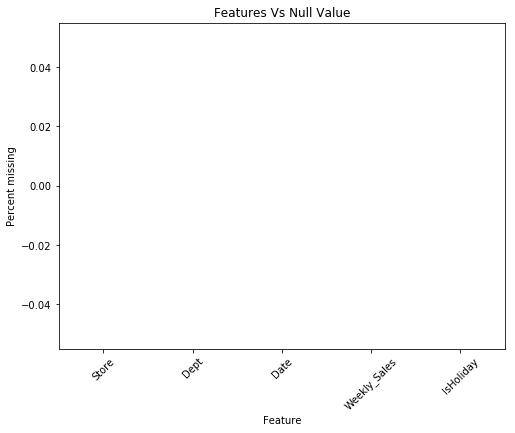

In [0]:
''' Deal with missing values. Calculating the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = df_test.isnull().sum()/len(df_test)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
plt.title('Features Vs Null Value')
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

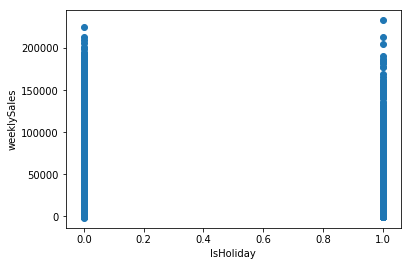

In [0]:
scatter(df_test, 'IsHoliday')

In [0]:
'''From the graph, we can see that maximum sale occured on holiday. 
This graph is disimilar from train dataset. '''

'From the graph, we can see that maximum sale occured on holiday. \nThis graph is disimilar from train dataset. '

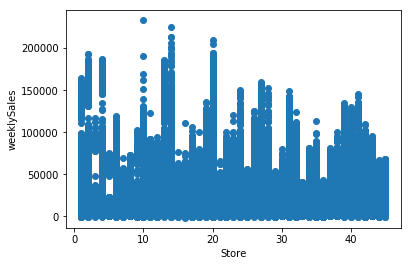

In [0]:
scatter(df_test, 'Store')

In [0]:
'''From the graph, we can deduct that maximum sale occured in store 10 which is same as the train data.
And the majority of weekly sale is below 200000'''

'From the graph, we can deduct that maximum sale occured in store 10 which is same as the train data.\nAnd the majority of weekly sale is below 200000'

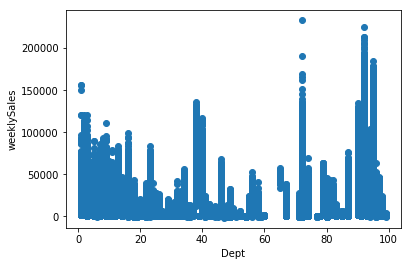

In [0]:
scatter(df_test, 'Dept')

In [0]:
'''From the graph, we can deduct that maximum sale occurs in dept 72 which is same as train dataset. '''

'From the graph, we can deduct that maximum sale occurs in dept 72 which is same as train dataset. '

# **Confirming our observations**

In [0]:
'''Here we can see the maximum weekly_sale is 233140.320000. Also an interesting observation is 
that weekly_sale contains NEGATIVE VALUE which is not acceptable. So we need remove records with negative
weekly sale from our dataframe'''
df_test["Weekly_Sales"].describe()

count    116570.000000
mean      15816.365134
std       22146.908346
min       -1699.000000
25%        1974.710000
50%        7480.085000
75%       20118.117500
max      233140.320000
Name: Weekly_Sales, dtype: float64

In [0]:
max_weekly_sale_test = df_test[df_test["Weekly_Sales"] == 233140.320000]
max_weekly_sale_test

,Store,Dept,Date,Weekly_Sales,IsHoliday
95436,10,72,2012-02-10,233140.32,True


# **Correlations between different variables in a dataframe:**

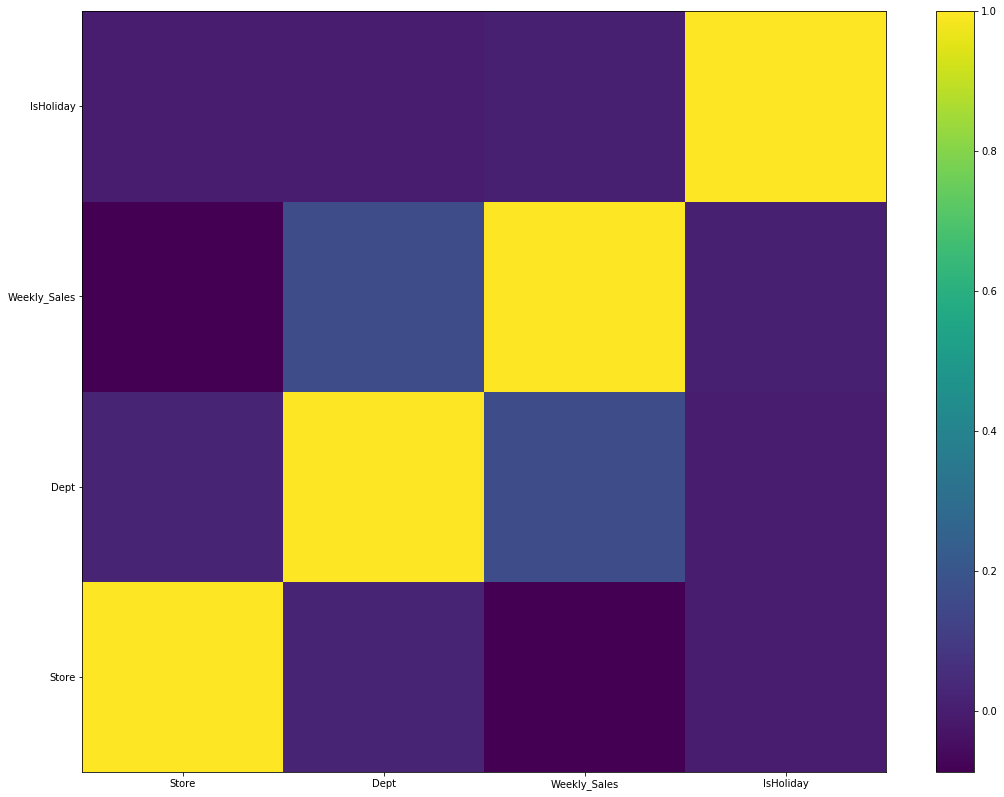

In [0]:
'''The correlation between variables in test dataset is similar to train dataset'''
fig = plt.figure(figsize=(18, 14))
corr = df_test.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

# **Drop records with negative weekly sale**

In [0]:
'''There are 375 records that contains weekly sale with negative value. Let us next check if there are any records 
with 0 weekly sale'''

neg_weekly_sale_test=df_test[df_test.Weekly_Sales < 0]
print (neg_weekly_sale_test.shape)

(372, 5)


In [0]:
'''We can see that there are 15 records with 0 weekly sale.'''
zero_weekly_sale_test = df_test[df_test["Weekly_Sales"] == 0]
print (zero_weekly_sale_test.shape)

(15, 5)


In [0]:
''' The negative weekly sale may be due to the misplaced negative sign while entering/inserting the weekly sale.
Since we cannot make assumptions, we are dropping these records '''
df_test_1=df_test[df_test.Weekly_Sales >= 0]
print (df_test_1.shape)

(116198, 5)


In [0]:
df_test_1.describe()

,Store,Dept,Weekly_Sales
count,116198.000000,116198.000000,116198.000000
mean,22.243429,44.437366,15867.179806
std,12.799173,30.662342,22164.084041
min,1.000000,1.000000,0.000000
25%,11.000000,18.000000,2017.112500
50%,22.000000,37.000000,7526.575000
75%,33.000000,74.000000,20174.340000
max,45.000000,99.000000,233140.320000


In [0]:
# Splitting dates
df_test_2 = split_dates(df_test_1,"Date")
print(df_test_2.shape)

(116198, 13)


In [0]:
# Converting string to category
df_test_3 = str_to_cat(df_test_2)
print(df_test_3.shape)
df_test_3.head(3)

(116198, 13)


,Store,Dept,Weekly_Sales,IsHoliday,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
119977,13,18,4234.71,False,2012,1,27,27,4,4,4,4,1
343640,36,46,2077.95,False,2012,1,27,27,4,4,4,4,1
121973,13,32,6484.50,False,2012,1,27,27,4,4,4,4,1


In [0]:
#Imputing null values based on entry in my_table.(my_table is null as  there were no null values in train dataset )
test_processed,my_table = mydf_preprocessor(df_test_3,null_table = my_table)
print(test_processed.shape)
test_processed.head(3)

(116198, 13)


,Store,Dept,Weekly_Sales,IsHoliday,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
119977,13,18,4234.71,False,2012,1,27,27,4,4,4,4,1
343640,36,46,2077.95,False,2012,1,27,27,4,4,4,4,1
121973,13,32,6484.50,False,2012,1,27,27,4,4,4,4,1


In [0]:
test_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116198 entries, 119977 to 421569
Data columns (total 13 columns):
Store           116198 non-null int64
Dept            116198 non-null int64
Weekly_Sales    116198 non-null float64
IsHoliday       116198 non-null bool
year            116198 non-null int64
month           116198 non-null int64
day             116198 non-null int64
dayofyear       116198 non-null int64
week            116198 non-null int64
weekofyear      116198 non-null int64
dayofweek       116198 non-null int64
weekday         116198 non-null int64
quarter         116198 non-null int64
dtypes: bool(1), float64(1), int64(11)
memory usage: 11.6 MB


In [0]:
Y_test = test_processed["Weekly_Sales"]
X_test = test_processed.drop(["Weekly_Sales"],axis = 1)

In [0]:
# for storing models and error results
model_list_mae = list()
model_list_med = list()
mae_list = list()
med_list = list()

# **Build and Train a k-NN Regression model**

In [0]:
my_knn_model = KNeighborsRegressor(n_neighbors = 1,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred_kNN = my_knn_model.predict(X_valid)

In [0]:
my_knn_model.score(X_valid, Y_valid)

0.9486915235811695

In [0]:
mae_valid_kNN = mean_absolute_error(Y_valid, Y_pred_kNN)
mae_valid_kNN

2453.5843797491325

In [0]:
med_valid_kNN = median_absolute_error(Y_valid, Y_pred_kNN)
med_valid_kNN

867.0499999999956

**Hyperparameter tuning**

In [0]:
from sklearn.metrics import accuracy_score

num_neighs = list()
accuracy_list = list()


for neighbor in range(1,20):
    my_knn_model = KNeighborsRegressor(n_neighbors = neighbor,weights = 'uniform')
    my_knn_model.fit(X_train,Y_train)
    #Y_pred = my_knn_model.predict(X_valid)
    accuracy = my_knn_model.score(X_valid,Y_valid)
    num_neighs.append(neighbor)
    accuracy_list.append(accuracy)

In [0]:
eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": accuracy_list})
eval_df

,Num of neighbors,Valid accuracy Score
0,1,0.948692
1,2,0.724055
2,3,0.692330
3,4,0.661807
4,5,0.602458
5,6,0.512580
6,7,0.483244
7,8,0.461982
8,9,0.431863
9,10,0.429456


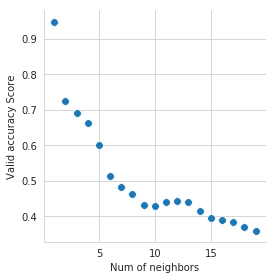

In [0]:
#Plot accuracy Vs validation set accuracy of the model
sns.set_style("whitegrid")
sns.pairplot(eval_df,x_vars = "Num of neighbors",
             y_vars = "Valid accuracy Score",plot_kws = {'s': 60},height = 4.0)

In [0]:
''' K = 1 '''


knn_model_fin = KNeighborsRegressor(n_neighbors = 1,weights = 'uniform')
knn_model_fin.fit(X,Y)



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='uniform')

**Validating on test data**

In [0]:
#Testing...
Y_test_pred_kNN = knn_model_fin.predict(X_test)

In [0]:
knn_model_fin.score(X_test, Y_test)

0.9476578002946363

In [0]:
mae_test_kNN = mean_absolute_error(Y_test, Y_test_pred_kNN)
mae_test_kNN

2150.8805752250464

In [0]:
med_test_kNN = median_absolute_error(Y_test, Y_test_pred_kNN)
med_test_kNN

819.0450000000003

In [0]:
model="KNeighborsRegressor"
model_list_mae.append(model)
model_list_med.append(model)
mae_list.append(mae_test_kNN)
med_list.append(med_test_kNN)

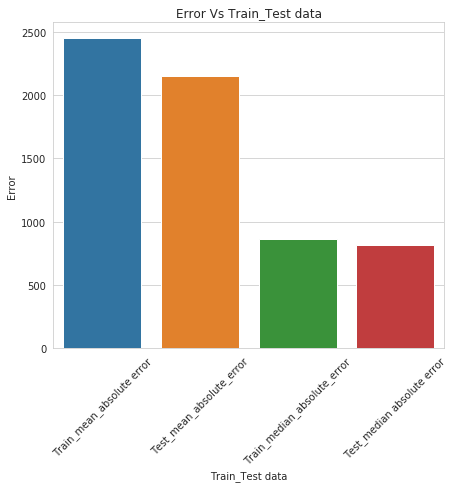

In [0]:
'''Visualizing train and test mean absolute error and median absolute error '''

plt.figure(figsize = (7,6))
plt.xticks(rotation=45)
plt.title('Error Vs Train_Test data')
plt.ylabel('Error')
plt.xlabel('Train_Test data')
x_number_list = [ "Train_mean_absolute error", "Test_mean_absolute_error", "Train_median_absolute_error", "Test_median absolute error" ]
y_number_list = [mae_valid_kNN, mae_test_kNN,med_valid_kNN,med_test_kNN]
sns.barplot(x = x_number_list,y = y_number_list)

# **Build and Train a Deep Neural Network**

In [0]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [0]:
# Function to create model, required for KerasRegressor
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=12, init='normal', activation='relu'))
    model.add(Dense(17, init='normal', activation='relu'))
    model.add(Dense(14, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation='relu'))
    model.add(Dense(5, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['mean_absolute_error'])
    return model

**Hyperparameter Tuning**

In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [0]:
# create model
estimator_model = KerasRegressor(build_fn=create_model,nb_epoch=2, batch_size=50000, verbose=0 )

In [0]:
# define the grid search parameters
batch_size = [10000,1000]
epochs = [1,5,25]

In [0]:
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=estimator_model, param_grid=param_grid, n_jobs=-1)

In [0]:
grid_result = grid.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
W0807 17:15:59.489659 140272602572672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=12, activation="relu", kernel_initializer="normal")`
  This is separate from the ipyk

In [0]:
'''The scores are negative MSE scores, i.e. negate them and you get the MSE. The thing is that GridSearchCV,
by convention, always tries to maximize its score so loss functions like MSE have to be negated.'''
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -13241.492356 using {'batch_size': 1000, 'epochs': 25}
-15923.900271 (226.283705) with: {'batch_size': 10000, 'epochs': 1}
-15865.222184 (230.885987) with: {'batch_size': 10000, 'epochs': 5}
-13263.455765 (185.318523) with: {'batch_size': 10000, 'epochs': 25}
-14701.990309 (668.614475) with: {'batch_size': 1000, 'epochs': 1}
-13266.627951 (182.152678) with: {'batch_size': 1000, 'epochs': 5}
-13241.492356 (197.387528) with: {'batch_size': 1000, 'epochs': 25}


In [0]:
# Fit the DNN with your train data and evaluate on validation data

history = estimator_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), nb_epoch=25, batch_size=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=12, activation="relu", kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(17, activation="relu", kernel_initializer="normal")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(14, activation="relu", kernel_initializer="normal")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="relu", kernel_initializer="normal")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense

In [0]:
y_pred_valid = estimator_model.predict(X_valid)

In [0]:
mae_valid_DNN = mean_absolute_error(Y_valid, y_pred_valid)
mae_valid_DNN

14414.509968687622

In [0]:
med_valid_DNN = median_absolute_error(Y_valid, y_pred_valid)
med_valid_DNN

6591.5748046875

**Epoch vs train-validation accuracy**

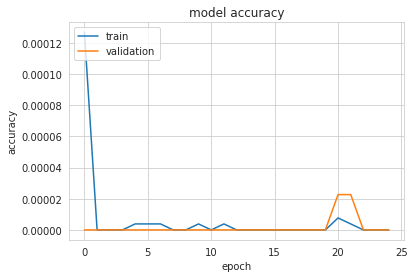

In [0]:
#accuracy vs epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Epoch vs train-validation loss**

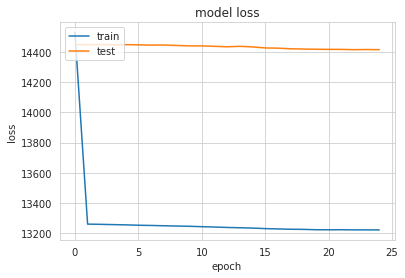

In [0]:
# epoch vs loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Validating on test data**

In [0]:
# Fit the DNN with your test data

history1 = estimator_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=25, batch_size=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=12, activation="relu", kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(17, activation="relu", kernel_initializer="normal")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(14, activation="relu", kernel_initializer="normal")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="relu", kernel_initializer="normal")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense

In [0]:
y_pred_test=estimator_model.predict(X_test)

In [0]:
mae_test_DNN = mean_absolute_error(Y_test, y_pred_test)
mae_test_DNN

13262.234066634413

In [0]:
med_test_DNN = median_absolute_error(Y_test, y_pred_test)
med_test_DNN

6488.158798828125

In [0]:
model = "Deep Neural Network"
model_list_mae.append(model)
model_list_med.append(model)
mae_list.append(mae_test_DNN)
med_list.append(med_test_DNN)

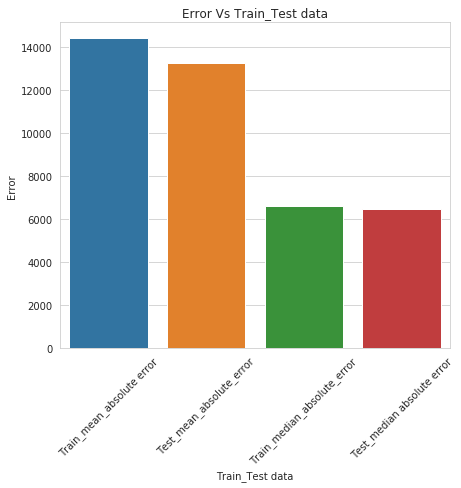

In [0]:
'''Visualizing train and test mean absolute error and median absolute error '''

plt.figure(figsize = (7,6))
plt.xticks(rotation=45)
plt.title('Error Vs Train_Test data')
plt.ylabel('Error')
plt.xlabel('Train_Test data')
x_number_list = [ "Train_mean_absolute error", "Test_mean_absolute_error", "Train_median_absolute_error", "Test_median absolute error" ]
y_number_list = [mae_valid_DNN, mae_test_DNN,med_valid_DNN,med_test_DNN]
sns.barplot(x = x_number_list,y = y_number_list)

# **Build and Train a XGBOOST model**

In [0]:
# create a regressor object 
XGregr = XGBRegressor(max_depth=100, random_state=1, learning_rate=0.1,n_estimators=100,eval_metric='mae')
XGregr.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:20:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=100, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
y_pred_XG = XGregr.predict(X_valid)

In [0]:

mae_valid_XG = mean_absolute_error(Y_valid, y_pred_XG)
mae_valid_XG

1918.6948022271831

In [0]:
med_valid_XG = median_absolute_error(Y_valid, y_pred_XG)
med_valid_XG

725.5493261718748

**Feature importance**

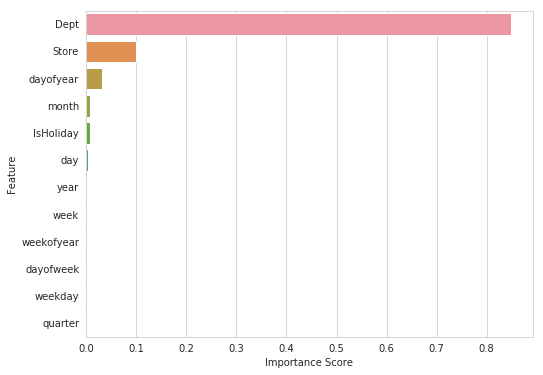

In [0]:
'''Calculate feature importance scores with your model'''

feat_imps = pd.DataFrame(XGregr.feature_importances_, index = X_train.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")

**Validating on test data**

In [0]:
ytest_pred_XG = XGregr.predict(X_test)

In [0]:

mae_test_XG = mean_absolute_error(Y_test, ytest_pred_XG)
mae_test_XG

1762.6826792373279

In [0]:

med_test_XG = median_absolute_error(Y_test, ytest_pred_XG)
med_test_XG

725.9247546386719

In [0]:
model="XGBRegressor"
model_list_mae.append(model)
model_list_med.append(model)
mae_list.append(mae_test_XG)
med_list.append(med_test_XG)

In [0]:
'''Visualizing train and test mean absolute error and median absolute error '''

plt.figure(figsize = (7,6))
plt.xticks(rotation=45)
plt.title('Error Vs Train_Test data')
plt.ylabel('Error')
plt.xlabel('Train_Test data')
x_number_list = [ "Train_mean_absolute error", "Test_mean_absolute_error", "Train_median_absolute_error", "Test_median absolute error" ]
y_number_list = [mae_valid_XG, mae_test_XG,med_valid_XG,med_test_XG]
sns.barplot(x = x_number_list,y = y_number_list)

# **Build and Train a Random Forest model**

In [0]:
# create a regressor object 
RFregr = RandomForestRegressor(max_depth=100, random_state=0, n_estimators=100)
RFregr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
y_pred_RF = RFregr.predict(X_valid)

In [0]:
mae_valid_RF = mean_absolute_error(Y_valid, y_pred_RF)
mae_valid_RF

2046.0238433846714

In [0]:
med_valid_RF = median_absolute_error(Y_valid, y_pred_RF)
med_valid_RF

721.3759999999929

**Feature importance**

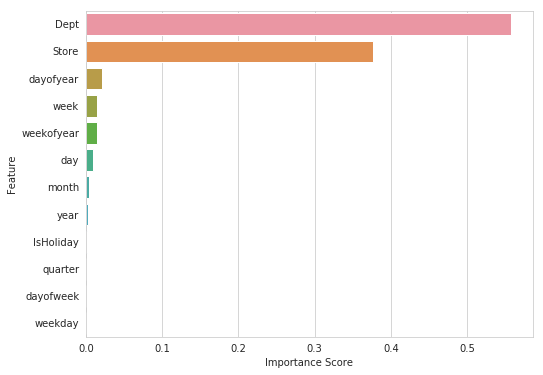

In [0]:
'''Calculate feature importance scores with your model'''

feat_imps = pd.DataFrame(RFregr.feature_importances_, index = X_train.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")

**Validating on test data**

In [0]:
ytest_pred_RF = RFregr.predict(X_test)

In [0]:
mae_test_RF = mean_absolute_error(Y_test, ytest_pred_RF)
mae_test_RF

1698.3042382588342

In [0]:
med_test_RF = median_absolute_error(Y_test, ytest_pred_RF)
med_test_RF

692.9462499999979

In [0]:
model="RandomForestRegressor"
model_list_mae.append(model)
model_list_med.append(model)
mae_list.append(mae_test_RF)
med_list.append(med_test_RF)

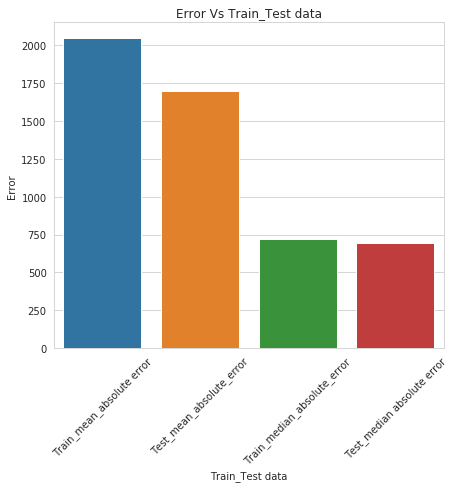

In [0]:
'''Visualizing train and test mean absolute error and median absolute error '''

plt.figure(figsize = (7,6))
plt.xticks(rotation=45)
plt.title('Error Vs Train_Test data')
plt.ylabel('Error')
plt.xlabel('Train_Test data')
x_number_list = [ "Train_mean_absolute error", "Test_mean_absolute_error", "Train_median_absolute_error", "Test_median absolute error" ]
y_number_list = [mae_valid_RF, mae_test_RF,med_valid_RF,med_test_RF]
sns.barplot(x = x_number_list,y = y_number_list)

# **Build and Train a Multivariate Regression model**

In [0]:
# There no difference even if the data is normalized or not
from sklearn.linear_model import LinearRegression
Lregr = LinearRegression(n_jobs=-1,normalize=True)
Lregr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [0]:
y_pred_L = Lregr.predict(X_valid)

In [0]:
mae_valid_L = mean_absolute_error(Y_valid, y_pred_L)
mae_valid_L

15837.691291764013

In [0]:
med_valid_L = median_absolute_error(Y_valid, y_pred_L)
med_valid_L

11438.23

**Validating on test data**

In [0]:
ytest_pred_L = Lregr.predict(X_test)

In [0]:
mae_test_L = mean_absolute_error(Y_test, ytest_pred_L)
mae_test_L

14604.093582677842

In [0]:
med_test_L = median_absolute_error(Y_test, ytest_pred_L)
med_test_L

10761.16

In [0]:
model="LinearRegression"
model_list_mae.append(model)
model_list_med.append(model)
mae_list.append(mae_test_L)
med_list.append(med_test_L)

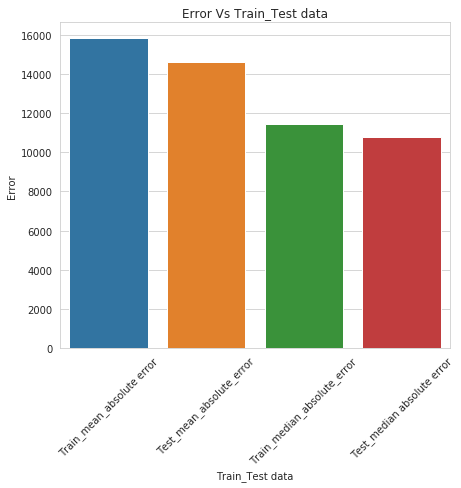

In [0]:
'''Visualizing train and test mean absolute error and median absolute error '''

plt.figure(figsize = (7,6))
plt.xticks(rotation=45)
plt.title('Error Vs Train_Test data')
plt.ylabel('Error')
plt.xlabel('Train_Test data')
x_number_list = [ "Train_mean_absolute error", "Test_mean_absolute_error", "Train_median_absolute_error", "Test_median absolute error" ]
y_number_list = [mae_valid_L, mae_test_L,med_valid_L,med_test_L]
sns.barplot(x = x_number_list,y = y_number_list)
 


# **Build and Train a ExtraTree Regression model**

In [0]:
from sklearn.ensemble import ExtraTreesRegressor
# create a regressor object 
ETregr = ExtraTreesRegressor(max_depth=100, random_state=1, n_estimators=100)
ETregr.fit(X_train, Y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=100,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=1, verbose=0,
                    warm_start=False)

In [0]:
y_pred_ET = ETregr.predict(X_valid)

In [0]:
mae_valid_ET = mean_absolute_error(Y_valid, y_pred_ET)
mae_valid_ET

1872.7324147435754

In [0]:
med_valid_ET = median_absolute_error(Y_valid, y_pred_ET)
med_valid_ET

719.6393999999709

**Feature importance**

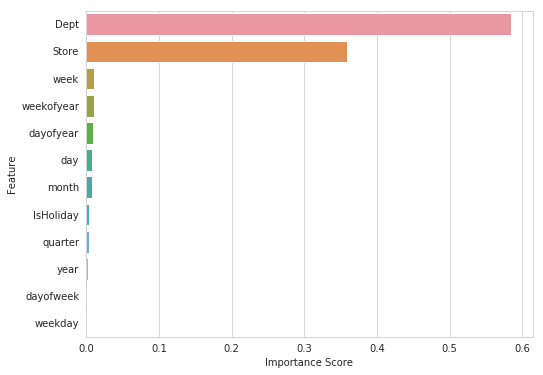

In [0]:
'''Calculate feature importance scores with your model'''

feat_imps = pd.DataFrame(ETregr.feature_importances_, index = X_train.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")

**Validating on test data**

In [0]:
ytest_pred_ET = ETregr.predict(X_test)

In [0]:
mae_test_ET = mean_absolute_error(Y_test, ytest_pred_ET)
mae_test_ET

1774.7862435618513

In [0]:
med_test_ET = median_absolute_error(Y_test, ytest_pred_ET)
med_test_ET

742.0529499999943

In [0]:
model="ExtraTreesRegressor"
model_list_mae.append(model)
model_list_med.append(model)
mae_list.append(mae_test_ET)
med_list.append(med_test_ET)

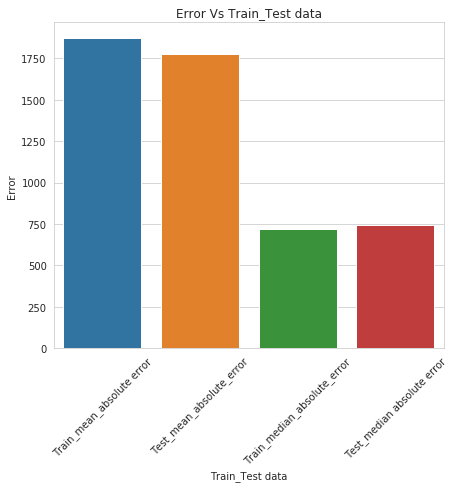

In [0]:
'''Visualizing train and test mean absolute error and median absolute error '''

plt.figure(figsize = (7,6))
plt.xticks(rotation=45)
plt.title('Error Vs Train_Test data')
plt.ylabel('Error')
plt.xlabel('Train_Test data')
x_number_list = [ "Train_mean_absolute error", "Test_mean_absolute_error", "Train_median_absolute_error", "Test_median absolute error" ]
y_number_list = [mae_valid_ET, mae_test_ET,med_valid_ET,med_test_ET]
sns.barplot(x = x_number_list,y = y_number_list)

# **Exploring the mean absolute error achieved by each model**

In [0]:
mean_performance_df =  pd.DataFrame({"Model": model_list_mae,"Mean absolute error": mae_list})
mean_performance_df

,Model,Mean absolute error
0,KNeighborsRegressor,2150.880575
1,Deep Neural Network,13262.234067
2,XGBRegressor,1762.682679
3,RandomForestRegressor,1698.304238
4,LinearRegression,14604.093583
5,ExtraTreesRegressor,1774.786244


In [0]:
# Sorting data based on mean absolute error
mean_performance_df.sort_values(by = ["Mean absolute error"],inplace = True)
print(mean_performance_df.head(5))

                   Model  Mean absolute error
3  RandomForestRegressor          1698.304238
2           XGBRegressor          1762.682679
5    ExtraTreesRegressor          1774.786244
0    KNeighborsRegressor          2150.880575
1    Deep Neural Network         13262.234067


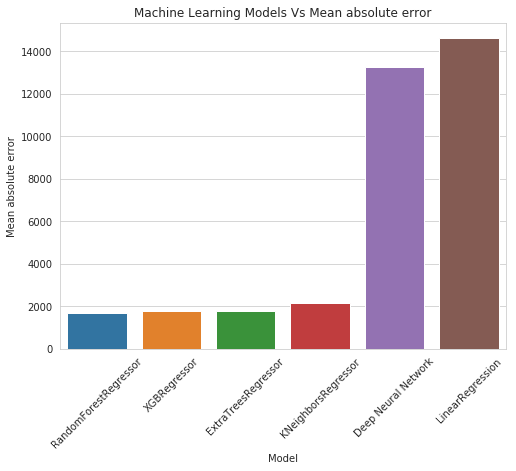

In [0]:
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
plt.title('Machine Learning Models Vs Mean absolute error')
sns.barplot(x = "Model",y ="Mean absolute error",data = mean_performance_df)

# **Exploring the median absolute error achieved by each model**

In [0]:
median_performance_df =  pd.DataFrame({"Model": model_list_med,"Median absolute error": med_list})
median_performance_df

,Model,Median absolute error
0,KNeighborsRegressor,819.045000
1,Deep Neural Network,6488.158799
2,XGBRegressor,725.924755
3,RandomForestRegressor,692.946250
4,LinearRegression,10761.160000
5,ExtraTreesRegressor,742.052950


In [0]:
# Sorting data based on median absolute error
median_performance_df.sort_values(by = ["Median absolute error"],inplace = True)
print(median_performance_df.head(5))

                   Model  Median absolute error
3  RandomForestRegressor             692.946250
2           XGBRegressor             725.924755
5    ExtraTreesRegressor             742.052950
0    KNeighborsRegressor             819.045000
1    Deep Neural Network            6488.158799


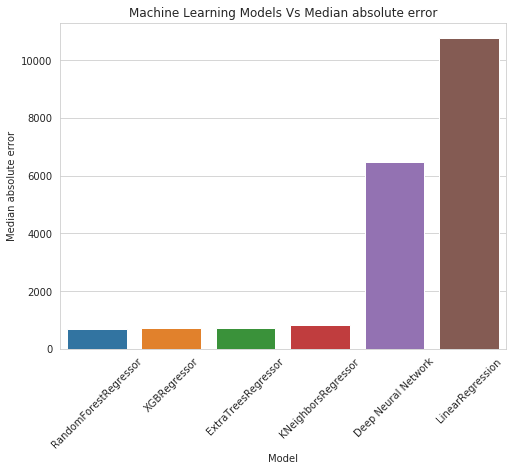

In [0]:
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
plt.title('Machine Learning Models Vs Median absolute error')
sns.barplot(x = "Model",y ="Median absolute error",data = median_performance_df)